# Lab13 Report

### st122314

# Proximal Policy Optimization (PPO)

### Actor and critic models

In [ ]:
process_device = "cuda"

In [ ]:
# model.py

from torch import nn
from torch.distributions import normal
import torch


class Actor(nn.Module):

    def __init__(self, n_states, n_actions):
        super(Actor, self).__init__()
        self.n_states = n_states
        self.n_actions = n_actions

        self.fc1 = nn.Linear(in_features=self.n_states, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.mu = nn.Linear(in_features=64, out_features=self.n_actions)

        self.log_std = nn.Parameter(torch.zeros(1, self.n_actions))

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight)
                layer.bias.data.zero_()

    def forward(self, inputs):
        x = inputs
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        mu = self.mu(x)

        std = self.log_std.exp()
        dist = normal.Normal(mu, std)

        return dist


class Critic(nn.Module):
    def __init__(self, n_states):
        super(Critic, self).__init__()
        self.n_states = n_states

        self.fc1 = nn.Linear(in_features=self.n_states, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.value = nn.Linear(in_features=64, out_features=1)

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight)
                layer.bias.data.zero_()

    def forward(self, inputs):
        x = inputs
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        value = self.value(x)

        return value

### Agent 

In [ ]:
# agent.py

# from model import Actor, Critic
from torch.optim import Adam
from torch import from_numpy
import numpy as np
import torch
from torch.optim.lr_scheduler import LambdaLR


class Agent:
    def __init__(self, env_name, n_iter, n_states, action_bounds, n_actions, lr):
        self.env_name = env_name
        self.n_iter = n_iter
        self.action_bounds = action_bounds
        self.n_actions = n_actions
        self.n_states = n_states
        self.device = torch.device(process_device)
        self.lr = lr
        
        self.current_policy = Actor(n_states=self.n_states,
                                    n_actions=self.n_actions).to(self.device)
        self.critic = Critic(n_states=self.n_states).to(self.device)

        self.actor_optimizer = Adam(self.current_policy.parameters(), lr=self.lr, eps=1e-5)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=self.lr, eps=1e-5)

        self.critic_loss = torch.nn.MSELoss()

        self.scheduler = lambda step: max(1.0 - float(step / self.n_iter), 0)

        self.actor_scheduler = LambdaLR(self.actor_optimizer, lr_lambda=self.scheduler)
        self.critic_scheduler = LambdaLR(self.actor_optimizer, lr_lambda=self.scheduler)

    def choose_dist(self, state):
        state = np.expand_dims(state, 0)
        state = from_numpy(state).float().to(self.device)
        with torch.no_grad():
            dist = self.current_policy(state)

        # action *= self.action_bounds[1]
        # action = np.clip(action, self.action_bounds[0], self.action_bounds[1])

        return dist

    def get_value(self, state):
        state = np.expand_dims(state, 0)
        state = from_numpy(state).float().to(self.device)
        with torch.no_grad():
            value = self.critic(state)

        return value.detach().cpu().numpy()

    def optimize(self, actor_loss, critic_loss):
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.current_policy.parameters(), 0.5)
        # torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.current_policy.parameters(), 0.5)
        # torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
        self.critic_optimizer.step()

    def schedule_lr(self):
        # self.total_scheduler.step()
        self.actor_scheduler.step()
        self.critic_scheduler.step()

    def save_weights(self, iteration, state_rms):
        torch.save({"current_policy_state_dict": self.current_policy.state_dict(),
                    "critic_state_dict": self.critic.state_dict(),
                    "actor_optimizer_state_dict": self.actor_optimizer.state_dict(),
                    "critic_optimizer_state_dict": self.critic_optimizer.state_dict(),
                    "actor_scheduler_state_dict": self.actor_scheduler.state_dict(),
                    "critic_scheduler_state_dict": self.critic_scheduler.state_dict(),
                    "iteration": iteration,
                    "state_rms_mean": state_rms.mean,
                    "state_rms_var": state_rms.var,
                    "state_rms_count": state_rms.count}, self.env_name + "_weights.pth")

    def load_weights(self):
        checkpoint = torch.load(self.env_name + "_weights.pth")
        self.current_policy.load_state_dict(checkpoint["current_policy_state_dict"])
        self.critic.load_state_dict(checkpoint["critic_state_dict"])
        self.actor_optimizer.load_state_dict(checkpoint["actor_optimizer_state_dict"])
        self.critic_optimizer.load_state_dict(checkpoint["critic_optimizer_state_dict"])
        self.actor_scheduler.load_state_dict(checkpoint["actor_scheduler_state_dict"])
        self.critic_scheduler.load_state_dict(checkpoint["critic_scheduler_state_dict"])
        iteration = checkpoint["iteration"]
        state_rms_mean = checkpoint["state_rms_mean"]
        state_rms_var = checkpoint["state_rms_var"]

        return iteration, state_rms_mean, state_rms_var

    def set_to_eval_mode(self):
        self.current_policy.eval()
        self.critic.eval()

    def set_to_train_mode(self):
        self.current_policy.train()
        self.critic.train()

### State normalization

In [ ]:
# running_mean_std.py

import numpy as np


class RunningMeanStd(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    # -> It's indeed batch normalization :D
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)


def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count

### Evaluate model function

In [ ]:
# test.py

import numpy as np


def evaluate_model(agent, env, state_rms, action_bounds):
    total_rewards = 0
    s = env.reset()
    done = False
    while not done:
        s = np.clip((s - state_rms.mean) / (state_rms.var ** 0.5 + 1e-8), -5.0, 5.0)
        dist = agent.choose_dist(s)
        action = dist.sample().cpu().numpy()[0]
        # action = np.clip(action, action_bounds[0], action_bounds[1])
        next_state, reward, done, _ = env.step(action)
        # env.render()
        s = next_state
        total_rewards += reward
    # env.close()
    return total_rewards

In [ ]:
# train.py

import torch
import numpy as np
import time
# from running_mean_std import RunningMeanStd
# from test import evaluate_model
from torch.utils.tensorboard import SummaryWriter


class Train:
    def __init__(self, env, test_env, env_name, n_iterations, agent, epochs, mini_batch_size, epsilon, horizon):
        self.env = env
        self.env_name = env_name
        self.test_env = test_env
        self.agent = agent
        self.epsilon = epsilon
        self.horizon = horizon
        self.epochs = epochs
        self.mini_batch_size = mini_batch_size
        self.n_iterations = n_iterations

        self.start_time = 0
        self.state_rms = RunningMeanStd(shape=(self.agent.n_states,))

        self.running_reward = 0

    @staticmethod
    def choose_mini_batch(mini_batch_size, states, actions, returns, advs, values, log_probs):
        full_batch_size = len(states)
        for _ in range(full_batch_size // mini_batch_size):
            indices = np.random.randint(0, full_batch_size, mini_batch_size)
            yield states[indices], actions[indices], returns[indices], advs[indices], values[indices],\
                  log_probs[indices]

    def train(self, states, actions, advs, values, log_probs):

        values = np.vstack(values[:-1])
        log_probs = np.vstack(log_probs)
        returns = advs + values
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        actions = np.vstack(actions)
        for epoch in range(self.epochs):
            for state, action, return_, adv, old_value, old_log_prob in self.choose_mini_batch(self.mini_batch_size,
                                                                                               states, actions, returns,
                                                                                               advs, values, log_probs):
                state = torch.Tensor(state).to(self.agent.device)
                action = torch.Tensor(action).to(self.agent.device)
                return_ = torch.Tensor(return_).to(self.agent.device)
                adv = torch.Tensor(adv).to(self.agent.device)
                old_value = torch.Tensor(old_value).to(self.agent.device)
                old_log_prob = torch.Tensor(old_log_prob).to(self.agent.device)

                value = self.agent.critic(state)
                # clipped_value = old_value + torch.clamp(value - old_value, -self.epsilon, self.epsilon)
                # clipped_v_loss = (clipped_value - return_).pow(2)
                # unclipped_v_loss = (value - return_).pow(2)
                # critic_loss = 0.5 * torch.max(clipped_v_loss, unclipped_v_loss).mean()
                critic_loss = self.agent.critic_loss(value, return_)

                new_log_prob = self.calculate_log_probs(self.agent.current_policy, state, action)

                ratio = (new_log_prob - old_log_prob).exp()
                actor_loss = self.compute_actor_loss(ratio, adv)

                self.agent.optimize(actor_loss, critic_loss)

        return actor_loss, critic_loss

    def step(self):
        state = self.env.reset()
        for iteration in range(1, 1 + self.n_iterations):
            states = []
            actions = []
            rewards = []
            values = []
            log_probs = []
            dones = []

            self.start_time = time.time()
            for t in range(self.horizon):
                # self.state_rms.update(state)
                state = np.clip((state - self.state_rms.mean) / (self.state_rms.var ** 0.5 + 1e-8), -5, 5)
                dist = self.agent.choose_dist(state)
                action = dist.sample()
                # action = np.clip(action, self.agent.action_bounds[0], self.agent.action_bounds[1])
                log_prob = dist.log_prob(action).cpu()
                action = action.cpu().numpy()[0]
                value = self.agent.get_value(state)
                next_state, reward, done, _ = self.env.step(action)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                values.append(value)
                log_probs.append(log_prob)
                dones.append(done)

                if done:
                    state = self.env.reset()
                else:
                    state = next_state
                    
            # self.state_rms.update(next_state)
            next_state = np.clip((next_state - self.state_rms.mean) / (self.state_rms.var ** 0.5 + 1e-8), -5, 5)
            next_value = self.agent.get_value(next_state) * (1 - done)
            values.append(next_value)

            advs = self.get_gae(rewards, values, dones)
            states = np.vstack(states)
            actor_loss, critic_loss = self.train(states, actions, advs, values, log_probs)
            # self.agent.set_weights()
            self.agent.schedule_lr()
            eval_rewards = evaluate_model(self.agent, self.test_env, self.state_rms, self.agent.action_bounds)
            self.state_rms.update(states)
            self.print_logs(iteration, actor_loss, critic_loss, eval_rewards)
            print("iteration: ", iteration, "\teval_rewards: ", eval_rewards)

    @staticmethod
    def get_gae(rewards, values, dones, gamma=0.99, lam=0.95):

        advs = []
        gae = 0

        dones.append(0)
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + gamma * (values[step + 1]) * (1 - dones[step]) - values[step]
            gae = delta + gamma * lam * (1 - dones[step]) * gae
            advs.append(gae)

        advs.reverse()
        return np.vstack(advs)

    @staticmethod
    def calculate_log_probs(model, states, actions):
        policy_distribution = model(states)
        return policy_distribution.log_prob(actions)

    def compute_actor_loss(self, ratio, adv):
        pg_loss1 = adv * ratio
        pg_loss2 = adv * torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon)
        loss = -torch.min(pg_loss1, pg_loss2).mean()
        return loss

    def print_logs(self, iteration, actor_loss, critic_loss, eval_rewards):
        if iteration == 1:
            self.running_reward = eval_rewards
        else:
            self.running_reward = self.running_reward * 0.99 + eval_rewards * 0.01

        if iteration % 100 == 0:
            print(f"Iter:{iteration}| "
                  f"Ep_Reward:{eval_rewards:.3f}| "
                  f"Running_reward:{self.running_reward:.3f}| "
                  f"Actor_Loss:{actor_loss:.3f}| "
                  f"Critic_Loss:{critic_loss:.3f}| "
                  f"Iter_duration:{time.time() - self.start_time:.3f}| "
                  f"lr:{self.agent.actor_scheduler.get_last_lr()}")
            self.agent.save_weights(iteration, self.state_rms)

        with SummaryWriter(self.env_name + "/logs") as writer:
            writer.add_scalar("Episode running reward", self.running_reward, iteration)
            writer.add_scalar("Episode reward", eval_rewards, iteration)
            writer.add_scalar("Actor loss", actor_loss, iteration)
            writer.add_scalar("Critic loss", critic_loss, iteration)

In [ ]:
# You need a DISPLAY for GlfwContext. For Jupyter, try
# export LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libGLEW.so
# xvfb-run -a -s "-screen 0 1400x900x24" jupyter lab --ip=<server-ip>

!echo $DISPLAY

In [ ]:
# Include this at the top of your colab code

import os

if not os.path.exists('.mujoco_setup_complete'):
    # Get the prereqs
    !apt-get -qq update
    !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
    # Get Mujoco
    !mkdir ~/.mujoco
    !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
    !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
    !rm mujoco.tar.gz
    # Add it to the actively loaded path and the bashrc path (these only do so much)
    !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc 
    !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc 
    # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
    !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
    !ldconfig
    # Install Mujoco-py
    !pip3 install -U 'mujoco-py<2.2,>=2.1'
    # run once
    !touch .mujoco_setup_complete

try:
    if _mujoco_run_once:
        pass
except NameError:
    _mujoco_run_once = False
    
if not _mujoco_run_once:
    # Add it to the actively loaded path and the bashrc path (these only do so much)
    try:
        os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
    except KeyError:
        os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
    try:
        os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
    except KeyError:
        os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
    # presetup so we don't see output on first env initialization
    import mujoco_py
    _mujoco_run_once = True

Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 155501 files and directories currently installed.)
Preparing to unpack .../0-libgl1-mesa-glx_20.0.8-0ubuntu1~18.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (20.0.8-0ubuntu1~18.04.1) ...
Selecting previously unselected package libglew2.0:amd64.
Preparing to unpack .../1-libglew2.0_2.0.0-5_amd64.deb ...
Unpacking libglew2.0:amd64 (2.0.0-5) ...
Selecting previously unselected package libglew-dev:amd64.
Preparing to unpack .../2-libglew-dev_2.0.0-5_amd64.deb ...
Unpacking libglew-dev:amd64 (2.0.0-5) ...
Selecting previously unselected package libglfw3:amd64.
Preparing to unpack .../3-libglfw3_3.2.1-1_amd64.deb ...
Unpacking libglfw3:amd64 (3.2.1-1) ...
Selecting previously unselected package patchelf.
Preparing to unpack .../4-patchelf_0.9-1_amd64.deb ...
Unpacking patchelf (0.9-1) ...
Selecting previously unselected package libosmesa6:amd64.
Preparing to unpack .../5-libosmesa6_20.0.8-0ubuntu1~18.0

In [ ]:
# play.py

from mujoco_py.generated import const
from mujoco_py import GlfwContext
import numpy as np
import cv2
#GlfwContext(offscreen=True)


class Play:
    def __init__(self, env, agent, env_name, max_episode=1):
        self.env = env
        self.max_episode = max_episode
        self.agent = agent
        _, self.state_rms_mean, self.state_rms_var = self.agent.load_weights()
        self.agent.set_to_eval_mode()
        self.device = torch.device(process_device)
        self.fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.VideoWriter = cv2.VideoWriter(env_name + ".avi", self.fourcc, 50.0, (250, 250))

    def evaluate(self):

        for _ in range(self.max_episode):
            s = self.env.reset()
            episode_reward = 0
            for _ in range(self.env._max_episode_steps):
                s = np.clip((s - self.state_rms_mean) / (self.state_rms_var ** 0.5 + 1e-8), -5.0, 5.0)
                dist = self.agent.choose_dist(s)
                action = dist.sample().cpu().numpy()[0]
                s_, r, done, _ = self.env.step(action)
                episode_reward += r
                if done:
                    break
                s = s_
                # self.env.render(mode="human")
                # self.env.viewer.cam.type = const.CAMERA_FIXED
                # self.env.viewer.cam.fixedcamid = 0
                # time.sleep(0.03)
                I = self.env.render(mode='rgb_array')
                I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)
                I = cv2.resize(I, (250, 250))
                self.VideoWriter.write(I)
                # cv2.imshow("env", I)
                # cv2.waitKey(10)
            print(f"episode reward:{episode_reward:3.3f}")
        self.env.close()
        self.VideoWriter.release()
        cv2.destroyAllWindows()

In [ ]:
import gym
import os
import mujoco_py
# from agent import Agent
# from train import Train
# from play import Play

In [ ]:
ENV_NAME = "InvertedDoublePendulum"
TRAIN_FLAG = True
test_env = gym.make(ENV_NAME + "-v2")

print(test_env.reset())

[-0.04889688  0.00470001 -0.03739779  0.99998895  0.99930046  0.10981682
 -0.22686602 -0.04755184  0.          0.          0.        ]


In [ ]:
n_states = test_env.observation_space.shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
n_actions = test_env.action_space.shape[0]

In [ ]:
# n_iterations = 500
n_iterations = 200
lr = 3e-4
epochs = 10
clip_range = 0.2
mini_batch_size = 64
T = 2048

In [ ]:
print(f"number of states:{n_states}\n"
      f"action bounds:{action_bounds}\n"
      f"number of actions:{n_actions}")

if not os.path.exists(ENV_NAME):
    os.mkdir(ENV_NAME)
    os.mkdir(ENV_NAME + "/logs")

env = gym.make(ENV_NAME + "-v2")

agent = Agent(n_states=n_states,
              n_iter=n_iterations,
              env_name=ENV_NAME,
              action_bounds=action_bounds,
              n_actions=n_actions,
              lr=lr)
if TRAIN_FLAG:
    trainer = Train(env=env,
                    test_env=test_env,
                    env_name=ENV_NAME,
                    agent=agent,
                    horizon=T,
                    n_iterations=n_iterations,
                    epochs=epochs,
                    mini_batch_size=mini_batch_size,
                    epsilon=clip_range)
    trainer.step()

player = Play(env, agent, ENV_NAME)
player.evaluate()

### Ant (4 legs animal)

In [ ]:
ENV_NAME = "Ant"
TRAIN_FLAG = True
test_env = gym.make(ENV_NAME + "-v2")

n_states = test_env.observation_space.shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
n_actions = test_env.action_space.shape[0]

In [ ]:
print(f"number of states:{n_states}\n"
      f"action bounds:{action_bounds}\n"
      f"number of actions:{n_actions}")

if not os.path.exists(ENV_NAME):
    os.mkdir(ENV_NAME)
    os.mkdir(ENV_NAME + "/logs")

env = gym.make(ENV_NAME + "-v2")

agent = Agent(n_states=n_states,
              n_iter=n_iterations,
              env_name=ENV_NAME,
              action_bounds=action_bounds,
              n_actions=n_actions,
              lr=lr)
if TRAIN_FLAG:
    trainer = Train(env=env,
                    test_env=test_env,
                    env_name=ENV_NAME,
                    agent=agent,
                    horizon=T,
                    n_iterations=n_iterations,
                    epochs=epochs,
                    mini_batch_size=mini_batch_size,
                    epsilon=clip_range)
    trainer.step()

player = Play(env, agent, ENV_NAME)
player.evaluate()

number of states:111
action bounds:[-1.0, 1.0]
number of actions:8
iteration:  1 	eval_rewards:  -422.17374568866836
iteration:  2 	eval_rewards:  -3243.8308376227956
iteration:  3 	eval_rewards:  -38.164450059129024
iteration:  4 	eval_rewards:  -186.24992453730675
iteration:  5 	eval_rewards:  -398.9249271273701
iteration:  6 	eval_rewards:  -125.90317860908169
iteration:  7 	eval_rewards:  -2682.0857415884975
iteration:  8 	eval_rewards:  -60.19074124542881
iteration:  9 	eval_rewards:  -223.80968566426688
iteration:  10 	eval_rewards:  -22.236191872180473
iteration:  11 	eval_rewards:  -46.47449037020863
iteration:  12 	eval_rewards:  -112.72958757010065
iteration:  13 	eval_rewards:  -198.86097335462006
iteration:  14 	eval_rewards:  -7.264166408747806
iteration:  15 	eval_rewards:  -80.21478054630954
iteration:  16 	eval_rewards:  -22.082756863453497
iteration:  17 	eval_rewards:  -196.61210540365178
iteration:  18 	eval_rewards:  -17.849292466450294
iteration:  19 	eval_rewards:

### FetchPickAndPlace

In [ ]:
ENV_NAME = "FetchPickAndPlace"
TRAIN_FLAG = True
test_env = gym.make(ENV_NAME + "-v1")

n_states = test_env.observation_space["observation"].shape[0]
n_achieveds = test_env.observation_space["achieved_goal"].shape[0]
n_goals = test_env.observation_space["desired_goal"].shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
n_actions = test_env.action_space.shape[0]

print(n_states)
print(n_goals)

env_dict = test_env.reset()

state = env_dict["observation"]
achieved_goal = env_dict["achieved_goal"]
desired_goal = env_dict["desired_goal"]

print(state)
print(achieved_goal)
print(desired_goal)

25
3
[ 1.34193265e+00  7.49100375e-01  5.34722720e-01  1.48432121e+00
  8.85913193e-01  4.24702091e-01  1.42388560e-01  1.36812818e-01
 -1.10020629e-01  2.91834773e-06 -4.72661656e-08 -3.85214084e-07
  5.92637053e-07  1.12208536e-13 -7.74656889e-06 -7.65027248e-08
  4.92570535e-05  1.88857148e-07 -2.90549459e-07 -1.18156686e-18
  7.73934983e-06  7.18103404e-08 -2.42928780e-06  4.93607091e-07
  1.70999820e-07]
[1.48432121 0.88591319 0.42470209]
[1.24591882 0.63620262 0.42469975]


In [ ]:
state = env_dict["observation"]
achieved_goal = env_dict["achieved_goal"]
desired_goal = env_dict["desired_goal"]

#state = np.expand_dims(state, axis=0)
#goal = np.expand_dims(desired_goal, axis=0)

with torch.no_grad():
    x = np.append(state, desired_goal)
    x = from_numpy(x).float()
    print(x)

tensor([ 1.3419e+00,  7.4910e-01,  5.3472e-01,  1.2466e+00,  6.4150e-01,
         4.2470e-01, -9.5375e-02, -1.0760e-01, -1.1002e-01,  2.9183e-06,
        -4.7266e-08, -3.8521e-07,  5.9264e-07,  1.1221e-13, -7.7466e-06,
        -7.6503e-08,  4.9257e-05,  1.8886e-07, -2.9055e-07, -1.1816e-18,
         7.7393e-06,  7.1810e-08, -2.4293e-06,  4.9361e-07,  1.7100e-07,
         1.3701e+00,  6.7018e-01,  4.2470e-01])


In [ ]:
def set_state(env_dict):
    state = env_dict["observation"]
    achieved_goal = env_dict["achieved_goal"]
    desired_goal = env_dict["desired_goal"]

    return np.append(state, desired_goal)

In [ ]:
def evaluate_model(agent, env, state_rms, action_bounds):
    total_rewards = 0
    s = env.reset()
    s = set_state(s)
    done = False
    while not done:
        s = np.clip((s - state_rms.mean) / (state_rms.var ** 0.5 + 1e-8), -5.0, 5.0)
        dist = agent.choose_dist(s)
        action = dist.sample().cpu().numpy()[0]
        # action = np.clip(action, action_bounds[0], action_bounds[1])
        next_state, reward, done, _ = env.step(action)
        next_state = set_state(next_state)
        # env.render()
        s = next_state
        total_rewards += reward
    # env.close()
    return total_rewards

In [ ]:
class Train:
    def __init__(self, env, test_env, env_name, n_iterations, agent, epochs, mini_batch_size, epsilon, horizon):
        self.env = env
        self.env_name = env_name
        self.test_env = test_env
        self.agent = agent
        self.epsilon = epsilon
        self.horizon = horizon
        self.epochs = epochs
        self.mini_batch_size = mini_batch_size
        self.n_iterations = n_iterations

        self.start_time = 0
        self.state_rms = RunningMeanStd(shape=(self.agent.n_states,))

        self.running_reward = 0

    @staticmethod
    def choose_mini_batch(mini_batch_size, states, actions, returns, advs, values, log_probs):
        full_batch_size = len(states)
        for _ in range(full_batch_size // mini_batch_size):
            indices = np.random.randint(0, full_batch_size, mini_batch_size)
            yield states[indices], actions[indices], returns[indices], advs[indices], values[indices],\
                  log_probs[indices]

    def train(self, states, actions, advs, values, log_probs):

        values = np.vstack(values[:-1])
        log_probs = np.vstack(log_probs)
        returns = advs + values
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        actions = np.vstack(actions)
        for epoch in range(self.epochs):
            for state, action, return_, adv, old_value, old_log_prob in self.choose_mini_batch(self.mini_batch_size,
                                                                                               states, actions, returns,
                                                                                               advs, values, log_probs):
                state = torch.Tensor(state).to(self.agent.device)
                action = torch.Tensor(action).to(self.agent.device)
                return_ = torch.Tensor(return_).to(self.agent.device)
                adv = torch.Tensor(adv).to(self.agent.device)
                old_value = torch.Tensor(old_value).to(self.agent.device)
                old_log_prob = torch.Tensor(old_log_prob).to(self.agent.device)

                value = self.agent.critic(state)
                # clipped_value = old_value + torch.clamp(value - old_value, -self.epsilon, self.epsilon)
                # clipped_v_loss = (clipped_value - return_).pow(2)
                # unclipped_v_loss = (value - return_).pow(2)
                # critic_loss = 0.5 * torch.max(clipped_v_loss, unclipped_v_loss).mean()
                critic_loss = self.agent.critic_loss(value, return_)

                new_log_prob = self.calculate_log_probs(self.agent.current_policy, state, action)

                ratio = (new_log_prob - old_log_prob).exp()
                actor_loss = self.compute_actor_loss(ratio, adv)

                self.agent.optimize(actor_loss, critic_loss)

        return actor_loss, critic_loss

    def step(self):
        state = self.env.reset()
        state = set_state(state)
        for iteration in range(1, 1 + self.n_iterations):
            states = []
            actions = []
            rewards = []
            values = []
            log_probs = []
            dones = []

            self.start_time = time.time()
            for t in range(self.horizon):
                # self.state_rms.update(state)
                state = np.clip((state - self.state_rms.mean) / (self.state_rms.var ** 0.5 + 1e-8), -5, 5)
                dist = self.agent.choose_dist(state)
                action = dist.sample()
                # action = np.clip(action, self.agent.action_bounds[0], self.agent.action_bounds[1])
                log_prob = dist.log_prob(action).cpu()
                action = action.cpu().numpy()[0]
                value = self.agent.get_value(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = set_state(next_state)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                values.append(value)
                log_probs.append(log_prob)
                dones.append(done)

                if done:
                    state = self.env.reset()
                    state = set_state(state)
                else:
                    state = next_state
            # self.state_rms.update(next_state)
            next_state = np.clip((next_state - self.state_rms.mean) / (self.state_rms.var ** 0.5 + 1e-8), -5, 5)
            next_value = self.agent.get_value(next_state) * (1 - done)
            values.append(next_value)

            advs = self.get_gae(rewards, values, dones)
            states = np.vstack(states)
            actor_loss, critic_loss = self.train(states, actions, advs, values, log_probs)
            # self.agent.set_weights()
            self.agent.schedule_lr()
            eval_rewards = evaluate_model(self.agent, self.test_env, self.state_rms, self.agent.action_bounds)
            self.state_rms.update(states)
            self.print_logs(iteration, actor_loss, critic_loss, eval_rewards)
            print("iteration: ", iteration, "\teval_rewards: ", eval_rewards)

    @staticmethod
    def get_gae(rewards, values, dones, gamma=0.99, lam=0.95):

        advs = []
        gae = 0

        dones.append(0)
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + gamma * (values[step + 1]) * (1 - dones[step]) - values[step]
            gae = delta + gamma * lam * (1 - dones[step]) * gae
            advs.append(gae)

        advs.reverse()
        return np.vstack(advs)

    @staticmethod
    def calculate_log_probs(model, states, actions):
        policy_distribution = model(states)
        return policy_distribution.log_prob(actions)

    def compute_actor_loss(self, ratio, adv):
        pg_loss1 = adv * ratio
        pg_loss2 = adv * torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon)
        loss = -torch.min(pg_loss1, pg_loss2).mean()
        return loss

    def print_logs(self, iteration, actor_loss, critic_loss, eval_rewards):
        if iteration == 1:
            self.running_reward = eval_rewards
        else:
            self.running_reward = self.running_reward * 0.99 + eval_rewards * 0.01

        if iteration % 100 == 0:
            print(f"Iter:{iteration}| "
                  f"Ep_Reward:{eval_rewards:.3f}| "
                  f"Running_reward:{self.running_reward:.3f}| "
                  f"Actor_Loss:{actor_loss:.3f}| "
                  f"Critic_Loss:{critic_loss:.3f}| "
                  f"Iter_duration:{time.time() - self.start_time:.3f}| "
                  f"lr:{self.agent.actor_scheduler.get_last_lr()}")
            self.agent.save_weights(iteration, self.state_rms)

        with SummaryWriter(self.env_name + "/logs") as writer:
            writer.add_scalar("Episode running reward", self.running_reward, iteration)
            writer.add_scalar("Episode reward", eval_rewards, iteration)
            writer.add_scalar("Actor loss", actor_loss, iteration)
            writer.add_scalar("Critic loss", critic_loss, iteration)

In [ ]:
#GlfwContext(offscreen=True)


class Play:
    def __init__(self, env, agent, env_name, max_episode=1):
        self.env = env
        self.max_episode = max_episode
        self.agent = agent
        _, self.state_rms_mean, self.state_rms_var = self.agent.load_weights()
        self.agent.set_to_eval_mode()
        self.device = torch.device(process_device)
        self.fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.VideoWriter = cv2.VideoWriter(env_name + ".avi", self.fourcc, 50.0, (250, 250))

    def evaluate(self):

        for _ in range(self.max_episode):
            s = self.env.reset()
            s = set_state(s)
            episode_reward = 0
            for _ in range(self.env._max_episode_steps):
                s = np.clip((s - self.state_rms_mean) / (self.state_rms_var ** 0.5 + 1e-8), -5.0, 5.0)
                dist = self.agent.choose_dist(s)
                action = dist.sample().cpu().numpy()[0]
                s_, r, done, _ = self.env.step(action)
                s_ = set_state(s_)
                episode_reward += r
                if done:
                    break
                s = s_
                # self.env.render(mode="human")
                # self.env.viewer.cam.type = const.CAMERA_FIXED
                # self.env.viewer.cam.fixedcamid = 0
                # time.sleep(0.03)
                I = self.env.render(mode='rgb_array')
                I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)
                I = cv2.resize(I, (250, 250))
                self.VideoWriter.write(I)
                # cv2.imshow("env", I)
                # cv2.waitKey(10)
            print(f"episode reward:{episode_reward:3.3f}")
        self.env.close()
        self.VideoWriter.release()
        cv2.destroyAllWindows()

In [ ]:
ENV_NAME = "FetchPickAndPlace"
TRAIN_FLAG = True
test_env = gym.make(ENV_NAME + "-v1")

n_states = test_env.observation_space["observation"].shape[0]
n_achieveds = test_env.observation_space["achieved_goal"].shape[0]
n_goals = test_env.observation_space["desired_goal"].shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
n_actions = test_env.action_space.shape[0]

In [ ]:
print(f"number of states:{n_states}\n"
      f"action bounds:{action_bounds}\n"
      f"number of actions:{n_actions}")

if not os.path.exists(ENV_NAME):
    os.mkdir(ENV_NAME)
    os.mkdir(ENV_NAME + "/logs")

env = gym.make(ENV_NAME + "-v1")

agent = Agent(n_states=n_states + n_goals,
              n_iter=n_iterations,
              env_name=ENV_NAME,
              action_bounds=action_bounds,
              n_actions=n_actions,
              lr=lr)
if TRAIN_FLAG:
    trainer = Train(env=env,
                    test_env=test_env,
                    env_name=ENV_NAME,
                    agent=agent,
                    horizon=T,
                    n_iterations=n_iterations,
                    epochs=epochs,
                    mini_batch_size=mini_batch_size,
                    epsilon=clip_range)
    trainer.step()

player = Play(env, agent, ENV_NAME)
player.evaluate()

number of states:25
action bounds:[-1.0, 1.0]
number of actions:4
iteration:  1 	eval_rewards:  -50.0
iteration:  2 	eval_rewards:  -50.0
iteration:  3 	eval_rewards:  -50.0
iteration:  4 	eval_rewards:  -50.0
iteration:  5 	eval_rewards:  -50.0
iteration:  6 	eval_rewards:  -50.0
iteration:  7 	eval_rewards:  -50.0
iteration:  8 	eval_rewards:  -50.0
iteration:  9 	eval_rewards:  -50.0
iteration:  10 	eval_rewards:  -50.0
iteration:  11 	eval_rewards:  -50.0
iteration:  12 	eval_rewards:  -50.0
iteration:  13 	eval_rewards:  -50.0
iteration:  14 	eval_rewards:  -50.0
iteration:  15 	eval_rewards:  -50.0
iteration:  16 	eval_rewards:  -50.0
iteration:  17 	eval_rewards:  -50.0
iteration:  18 	eval_rewards:  -50.0
iteration:  19 	eval_rewards:  -50.0
iteration:  20 	eval_rewards:  -50.0
iteration:  21 	eval_rewards:  -50.0
iteration:  22 	eval_rewards:  -50.0
iteration:  23 	eval_rewards:  -50.0
iteration:  24 	eval_rewards:  -50.0
iteration:  25 	eval_rewards:  -50.0
iteration:  26 	ev

# Deep Deterministic Policy Gradients (DDPG)


In [ ]:
from torch import nn
import torch
from torch.nn import functional as F
import numpy as np


def init_weights_biases(size):
    v = 1.0 / np.sqrt(size[0])
    return torch.FloatTensor(size).uniform_(-v, v)


class Actor(nn.Module):
    def __init__(self, n_states, n_actions, n_goals, n_hidden1=256, n_hidden2=256, n_hidden3=256, initial_w=3e-3):
        self.n_states = n_states[0]
        self.n_actions = n_actions
        self.n_goals = n_goals
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.initial_w = initial_w
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(in_features=self.n_states + self.n_goals, out_features=self.n_hidden1)
        self.fc2 = nn.Linear(in_features=self.n_hidden1, out_features=self.n_hidden2)
        self.fc3 = nn.Linear(in_features=self.n_hidden2, out_features=self.n_hidden3)
        self.output = nn.Linear(in_features=self.n_hidden3, out_features=self.n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = torch.tanh(self.output(x))  # TODO add scale of the action

        return output


class Critic(nn.Module):
    def __init__(self, n_states, n_goals, n_hidden1=256, n_hidden2=256, n_hidden3=256, initial_w=3e-3, action_size=1):
        self.n_states = n_states[0]
        self.n_goals = n_goals
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.initial_w = initial_w
        self.action_size = action_size
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(in_features=self.n_states + self.n_goals + self.action_size, out_features=self.n_hidden1)
        self.fc2 = nn.Linear(in_features=self.n_hidden1, out_features=self.n_hidden2)
        self.fc3 = nn.Linear(in_features=self.n_hidden2, out_features=self.n_hidden3)
        self.output = nn.Linear(in_features=self.n_hidden3, out_features=1)

    def forward(self, x, a):
        x = F.relu(self.fc1(torch.cat([x, a], dim=-1)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = self.output(x)

        return output

In [ ]:
import numpy as np
from copy import deepcopy as dc
import random


class Memory:
    def __init__(self, capacity, k_future, env):
        self.capacity = capacity
        self.memory = []
        self.memory_counter = 0
        self.memory_length = 0
        self.env = env

        self.future_p = 1 - (1. / (1 + k_future))

    def sample(self, batch_size):

        ep_indices = np.random.randint(0, len(self.memory), batch_size)
        time_indices = np.random.randint(0, len(self.memory[0]["next_state"]), batch_size)
        states = []
        actions = []
        desired_goals = []
        next_states = []
        next_achieved_goals = []

        for episode, timestep in zip(ep_indices, time_indices):
            states.append(dc(self.memory[episode]["state"][timestep]))
            actions.append(dc(self.memory[episode]["action"][timestep]))
            desired_goals.append(dc(self.memory[episode]["desired_goal"][timestep]))
            next_achieved_goals.append(dc(self.memory[episode]["next_achieved_goal"][timestep]))
            next_states.append(dc(self.memory[episode]["next_state"][timestep]))

        states = np.vstack(states)
        actions = np.vstack(actions)
        desired_goals = np.vstack(desired_goals)
        next_achieved_goals = np.vstack(next_achieved_goals)
        next_states = np.vstack(next_states)

        her_indices = np.where(np.random.uniform(size=batch_size) < self.future_p)
        future_offset = np.random.uniform(size=batch_size) * (len(self.memory[0]["next_state"]) - time_indices)
        future_offset = future_offset.astype(int)
        future_t = (time_indices + 1 + future_offset)[her_indices]

        future_ag = []
        for episode, f_offset in zip(ep_indices[her_indices], future_t):
            future_ag.append(dc(self.memory[episode]["achieved_goal"][f_offset]))
        future_ag = np.vstack(future_ag)

        desired_goals[her_indices] = future_ag
        rewards = np.expand_dims(self.env.compute_reward(next_achieved_goals, desired_goals, None), 1)

        return self.clip_obs(states), actions, rewards, self.clip_obs(next_states), self.clip_obs(desired_goals)

    def add(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
        assert len(self.memory) <= self.capacity

    def __len__(self):
        return len(self.memory)

    @staticmethod
    def clip_obs(x):
        return np.clip(x, -200, 200)

    def sample_for_normalization(self, batch):
        size = len(batch[0]["next_state"])
        ep_indices = np.random.randint(0, len(batch), size)
        time_indices = np.random.randint(0, len(batch[0]["next_state"]), size)
        states = []
        desired_goals = []

        for episode, timestep in zip(ep_indices, time_indices):
            states.append(dc(batch[episode]["state"][timestep]))
            desired_goals.append(dc(batch[episode]["desired_goal"][timestep]))

        states = np.vstack(states)
        desired_goals = np.vstack(desired_goals)

        her_indices = np.where(np.random.uniform(size=size) < self.future_p)
        future_offset = np.random.uniform(size=size) * (len(batch[0]["next_state"]) - time_indices)
        future_offset = future_offset.astype(int)
        future_t = (time_indices + 1 + future_offset)[her_indices]

        future_ag = []
        for episode, f_offset in zip(ep_indices[her_indices], future_t):
            future_ag.append(dc(batch[episode]["achieved_goal"][f_offset]))
        future_ag = np.vstack(future_ag)

        desired_goals[her_indices] = future_ag

        return self.clip_obs(states), self.clip_obs(desired_goals)

In [ ]:
!pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185319 sha256=83430d85c27cb47cdf848b108f935a7fb28a076584ec5a6d59f7d28d0a298030
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [ ]:
import threading
import numpy as np
from mpi4py import MPI


class Normalizer:
    def __init__(self, size, eps=1e-2, default_clip_range=np.inf):
        self.size = size
        self.eps = eps
        self.default_clip_range = default_clip_range
        # some local information
        self.local_sum = np.zeros(self.size, np.float32)
        self.local_sumsq = np.zeros(self.size, np.float32)
        self.local_count = np.zeros(1, np.float32)
        # get the total sum sumsq and sum count
        self.total_sum = np.zeros(self.size, np.float32)
        self.total_sumsq = np.zeros(self.size, np.float32)
        self.total_count = np.ones(1, np.float32)
        # get the mean and std
        self.mean = np.zeros(self.size, np.float32)
        self.std = np.ones(self.size, np.float32)
        # thread locker
        self.lock = threading.Lock()

    # update the parameters of the normalizer
    def update(self, v):
        v = v.reshape(-1, self.size)
        # do the computing
        with self.lock:
            self.local_sum += v.sum(axis=0)
            self.local_sumsq += (np.square(v)).sum(axis=0)
            self.local_count[0] += v.shape[0]

    # sync the parameters across the cpus
    def sync(self, local_sum, local_sumsq, local_count):
        local_sum[...] = self._mpi_average(local_sum)
        local_sumsq[...] = self._mpi_average(local_sumsq)
        local_count[...] = self._mpi_average(local_count)
        return local_sum, local_sumsq, local_count

    def recompute_stats(self):
        with self.lock:
            local_count = self.local_count.copy()
            local_sum = self.local_sum.copy()
            local_sumsq = self.local_sumsq.copy()
            # reset
            self.local_count[...] = 0
            self.local_sum[...] = 0
            self.local_sumsq[...] = 0
        # sync the stats
        sync_sum, sync_sumsq, sync_count = self.sync(local_sum, local_sumsq, local_count)
        # update the total stuff
        self.total_sum += sync_sum
        self.total_sumsq += sync_sumsq
        self.total_count += sync_count
        # calculate the new mean and std
        self.mean = self.total_sum / self.total_count
        self.std = np.sqrt(np.maximum(np.square(self.eps), (self.total_sumsq / self.total_count) - np.square(
            self.total_sum / self.total_count)))

    # average across the cpu's data
    def _mpi_average(self, x):
        buf = np.zeros_like(x)
        MPI.COMM_WORLD.Allreduce(x, buf, op=MPI.SUM)
        buf /= MPI.COMM_WORLD.Get_size()
        return buf

    # normalize the observation
    def normalize(self, v, clip_range=None):
        if clip_range is None:
            clip_range = self.default_clip_range
        return np.clip((v - self.mean) / self.std, -clip_range, clip_range)


### Agent Class

In [ ]:
import torch
from torch import from_numpy, device
import numpy as np
# from models import Actor, Critic
# from memory import Memory
from torch.optim import Adam
from mpi4py import MPI
# from normalizer import Normalizer


class Agent:
    def __init__(self, n_states, n_actions, n_goals, action_bounds, capacity, env,
                 k_future,
                 batch_size,
                 action_size=1,
                 tau=0.05,
                 actor_lr=1e-3,
                 critic_lr=1e-3,
                 gamma=0.98):
        self.device = device("cpu")
        self.n_states = n_states
        self.n_actions = n_actions
        self.n_goals = n_goals
        self.k_future = k_future
        self.action_bounds = action_bounds
        self.action_size = action_size
        self.env = env

        self.actor = Actor(self.n_states, n_actions=self.n_actions, n_goals=self.n_goals).to(self.device)
        self.critic = Critic(self.n_states, action_size=self.action_size, n_goals=self.n_goals).to(self.device)
        self.sync_networks(self.actor)
        self.sync_networks(self.critic)
        self.actor_target = Actor(self.n_states, n_actions=self.n_actions, n_goals=self.n_goals).to(self.device)
        self.critic_target = Critic(self.n_states, action_size=self.action_size, n_goals=self.n_goals).to(self.device)
        self.init_target_networks()
        self.tau = tau
        self.gamma = gamma

        self.capacity = capacity
        self.memory = Memory(self.capacity, self.k_future, self.env)

        self.batch_size = batch_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.actor_optim = Adam(self.actor.parameters(), self.actor_lr)
        self.critic_optim = Adam(self.critic.parameters(), self.critic_lr)

        self.state_normalizer = Normalizer(self.n_states[0], default_clip_range=5)
        self.goal_normalizer = Normalizer(self.n_goals, default_clip_range=5)

    def choose_action(self, state, goal, train_mode=True):
        state = self.state_normalizer.normalize(state)
        goal = self.goal_normalizer.normalize(goal)
        state = np.expand_dims(state, axis=0)
        goal = np.expand_dims(goal, axis=0)

        with torch.no_grad():
            x = np.concatenate([state, goal], axis=1)
            x = from_numpy(x).float().to(self.device)
            action = self.actor(x)[0].cpu().data.numpy()

        if train_mode:
            action += 0.2 * np.random.randn(self.n_actions)
            action = np.clip(action, self.action_bounds[0], self.action_bounds[1])

            random_actions = np.random.uniform(low=self.action_bounds[0], high=self.action_bounds[1],
                                               size=self.n_actions)
            action += np.random.binomial(1, 0.3, 1)[0] * (random_actions - action)

        return action

    def store(self, mini_batch):
        for batch in mini_batch:
            self.memory.add(batch)
        self._update_normalizer(mini_batch)

    def init_target_networks(self):
        self.hard_update_networks(self.actor, self.actor_target)
        self.hard_update_networks(self.critic, self.critic_target)

    @staticmethod
    def hard_update_networks(local_model, target_model):
        target_model.load_state_dict(local_model.state_dict())

    @staticmethod
    def soft_update_networks(local_model, target_model, tau=0.05):
        for t_params, e_params in zip(target_model.parameters(), local_model.parameters()):
            t_params.data.copy_(tau * e_params.data + (1 - tau) * t_params.data)

    def train(self):
        states, actions, rewards, next_states, goals = self.memory.sample(self.batch_size)

        states = self.state_normalizer.normalize(states)
        next_states = self.state_normalizer.normalize(next_states)
        goals = self.goal_normalizer.normalize(goals)
        inputs = np.concatenate([states, goals], axis=1)
        next_inputs = np.concatenate([next_states, goals], axis=1)

        inputs = torch.Tensor(inputs).to(self.device)
        rewards = torch.Tensor(rewards).to(self.device)
        next_inputs = torch.Tensor(next_inputs).to(self.device)
        actions = torch.Tensor(actions).to(self.device)

        with torch.no_grad():
            target_q = self.critic_target(next_inputs, self.actor_target(next_inputs))
            target_returns = rewards + self.gamma * target_q.detach()
            target_returns = torch.clamp(target_returns, -1 / (1 - self.gamma), 0)

        q_eval = self.critic(inputs, actions)
        critic_loss = (target_returns - q_eval).pow(2).mean()

        a = self.actor(inputs)
        actor_loss = -self.critic(inputs, a).mean()
        actor_loss += a.pow(2).mean()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.sync_grads(self.actor)
        self.actor_optim.step()

        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.sync_grads(self.critic)
        self.critic_optim.step()

        return actor_loss.item(), critic_loss.item()

    def save_weights(self):
        torch.save({"actor_state_dict": self.actor.state_dict(),
                    "state_normalizer_mean": self.state_normalizer.mean,
                    "state_normalizer_std": self.state_normalizer.std,
                    "goal_normalizer_mean": self.goal_normalizer.mean,
                    "goal_normalizer_std": self.goal_normalizer.std}, "FetchPickAndPlace.pth")
                    #"goal_normalizer_std": self.goal_normalizer.std}, "FetchSlide.pth")
                    #"goal_normalizer_std": self.goal_normalizer.std}, "HandReach.pth")
        

    def load_weights(self):

        #checkpoint = torch.load("FetchSlide.pth")
        checkpoint = torch.load("FetchPickAndPlace.pth")
        #checkpoint = torch.load("FetchPickAndPlace.pth")

        actor_state_dict = checkpoint["actor_state_dict"]
        self.actor.load_state_dict(actor_state_dict)
        state_normalizer_mean = checkpoint["state_normalizer_mean"]
        self.state_normalizer.mean = state_normalizer_mean
        state_normalizer_std = checkpoint["state_normalizer_std"]
        self.state_normalizer.std = state_normalizer_std
        goal_normalizer_mean = checkpoint["goal_normalizer_mean"]
        self.goal_normalizer.mean = goal_normalizer_mean
        goal_normalizer_std = checkpoint["goal_normalizer_std"]
        self.goal_normalizer.std = goal_normalizer_std

    def set_to_eval_mode(self):
        self.actor.eval()
        # self.critic.eval()

    def update_networks(self):
        self.soft_update_networks(self.actor, self.actor_target, self.tau)
        self.soft_update_networks(self.critic, self.critic_target, self.tau)

    def _update_normalizer(self, mini_batch):
        states, goals = self.memory.sample_for_normalization(mini_batch)

        self.state_normalizer.update(states)
        self.goal_normalizer.update(goals)
        self.state_normalizer.recompute_stats()
        self.goal_normalizer.recompute_stats()

    @staticmethod
    def sync_networks(network):
        comm = MPI.COMM_WORLD
        flat_params = _get_flat_params_or_grads(network, mode='params')
        comm.Bcast(flat_params, root=0)
        _set_flat_params_or_grads(network, flat_params, mode='params')

    @staticmethod
    def sync_grads(network):
        flat_grads = _get_flat_params_or_grads(network, mode='grads')
        comm = MPI.COMM_WORLD
        global_grads = np.zeros_like(flat_grads)
        comm.Allreduce(flat_grads, global_grads, op=MPI.SUM)
        _set_flat_params_or_grads(network, global_grads, mode='grads')


def _get_flat_params_or_grads(network, mode='params'):
    attr = 'data' if mode == 'params' else 'grad'
    return np.concatenate([getattr(param, attr).cpu().numpy().flatten() for param in network.parameters()])


def _set_flat_params_or_grads(network, flat_params, mode='params'):
    attr = 'data' if mode == 'params' else 'grad'
    pointer = 0
    for param in network.parameters():
        getattr(param, attr).copy_(
            torch.tensor(flat_params[pointer:pointer + param.data.numel()]).view_as(param.data))
        pointer += param.data.numel()

### Play class (run and record the vdo)

In [ ]:
import torch
from torch import device
import numpy as np
import cv2
from gym import wrappers
from mujoco_py import GlfwContext

#GlfwContext(offscreen=True)

from mujoco_py.generated import const


class Play:
    def __init__(self, env, agent, max_episode=4):
        self.env = env
        self.env = wrappers.Monitor(env, "./videos", video_callable=lambda episode_id: True, force=True)
        self.max_episode = max_episode
        self.agent = agent
        self.agent.load_weights()
        self.agent.set_to_eval_mode()
        self.device = device("cuda" if torch.cuda.is_available() else "cpu")

    def evaluate(self):

        for _ in range(self.max_episode):
            env_dict = self.env.reset()
            state = env_dict["observation"]
            achieved_goal = env_dict["achieved_goal"]
            desired_goal = env_dict["desired_goal"]
            while np.linalg.norm(achieved_goal - desired_goal) <= 0.05:
                env_dict = self.env.reset()
                state = env_dict["observation"]
                achieved_goal = env_dict["achieved_goal"]
                desired_goal = env_dict["desired_goal"]
            done = False
            episode_reward = 0
            while not done:
                action = self.agent.choose_action(state, desired_goal, train_mode=False)
                next_env_dict, r, done, _ = self.env.step(action)
                next_state = next_env_dict["observation"]
                next_desired_goal = next_env_dict["desired_goal"]
                episode_reward += r
                state = next_state.copy()
                desired_goal = next_desired_goal.copy()
                I = self.env.render(mode="rgb_array")  # mode = "rgb_array
                self.env.viewer.cam.type = const.CAMERA_FREE
                self.env.viewer.cam.fixedcamid = 0
                # I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)
                # cv2.imshow("I", I)
                # cv2.waitKey(2)
            print(f"episode_reward:{episode_reward:3.3f}")

        self.env.close()

Epoch:0| Running_reward:-50.000| EP_reward:-50.000| Memory_length:100| Duration:78.810| Actor_Loss:0.517| Critic_Loss:0.001| Success rate:0.000| 2.2/12.7 GB RAM
Epoch:1| Running_reward:-50.000| EP_reward:-50.000| Memory_length:200| Duration:80.369| Actor_Loss:0.951| Critic_Loss:0.005| Success rate:0.000| 2.2/12.7 GB RAM
Epoch:2| Running_reward:-50.000| EP_reward:-50.000| Memory_length:300| Duration:81.550| Actor_Loss:1.486| Critic_Loss:0.018| Success rate:0.000| 2.2/12.7 GB RAM
Epoch:3| Running_reward:-50.000| EP_reward:-50.000| Memory_length:400| Duration:82.133| Actor_Loss:1.880| Critic_Loss:0.011| Success rate:0.000| 2.2/12.7 GB RAM
Epoch:4| Running_reward:-50.000| EP_reward:-50.000| Memory_length:500| Duration:81.919| Actor_Loss:2.033| Critic_Loss:0.009| Success rate:0.000| 2.2/12.7 GB RAM
Epoch:5| Running_reward:-50.000| EP_reward:-50.000| Memory_length:600| Duration:82.451| Actor_Loss:2.467| Critic_Loss:0.008| Success rate:0.000| 2.2/12.7 GB RAM
Epoch:6| Running_reward:-50.000| E

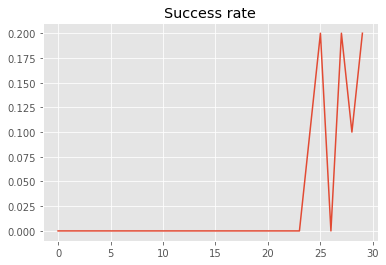

In [ ]:
import gym
# from agent import Agent
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
# from play import Play
import mujoco_py
import random
from mpi4py import MPI
import psutil
import time
from copy import deepcopy as dc
import os
import torch

ENV_NAME = "FetchPickAndPlace-v1"
INTRO = False
Train = True
Play_FLAG = False
MAX_EPOCHS = 30
MAX_CYCLES = 50
num_updates = 40
MAX_EPISODES = 2
memory_size = 7e+5 // 50
batch_size = 256
actor_lr = 1e-3
critic_lr = 1e-3
gamma = 0.98
tau = 0.05
k_future = 4

test_env = gym.make(ENV_NAME)
state_shape = test_env.observation_space.spaces["observation"].shape
n_actions = test_env.action_space.shape[0]
n_goals = test_env.observation_space.spaces["desired_goal"].shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
to_gb = lambda in_bytes: in_bytes / 1024 / 1024 / 1024

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['IN_MPI'] = '1'


def eval_agent(env_, agent_):
    total_success_rate = []
    running_r = []
    for ep in range(10):
        per_success_rate = []
        env_dictionary = env_.reset()
        s = env_dictionary["observation"]
        ag = env_dictionary["achieved_goal"]
        g = env_dictionary["desired_goal"]
        while np.linalg.norm(ag - g) <= 0.05:
            env_dictionary = env_.reset()
            s = env_dictionary["observation"]
            ag = env_dictionary["achieved_goal"]
            g = env_dictionary["desired_goal"]
        ep_r = 0
        for t in range(50):
            with torch.no_grad():
                a = agent_.choose_action(s, g, train_mode=False)
            observation_new, r, _, info_ = env_.step(a)
            s = observation_new['observation']
            g = observation_new['desired_goal']
            per_success_rate.append(info_['is_success'])
            ep_r += r
        total_success_rate.append(per_success_rate)
        if ep == 0:
            running_r.append(ep_r)
        else:
            running_r.append(running_r[-1] * 0.99 + 0.01 * ep_r)
    total_success_rate = np.array(total_success_rate)
    local_success_rate = np.mean(total_success_rate[:, -1])
    global_success_rate = MPI.COMM_WORLD.allreduce(local_success_rate, op=MPI.SUM)
    return global_success_rate / MPI.COMM_WORLD.Get_size(), running_r, ep_r

if INTRO:
    print(f"state_shape:{state_shape[0]}\n"
          f"number of actions:{n_actions}\n"
          f"action boundaries:{action_bounds}\n"
          f"max timesteps:{test_env._max_episode_steps}")
    for _ in range(3):
        done = False
        test_env.reset()
        while not done:
            action = test_env.action_space.sample()
            test_state, test_reward, test_done, test_info = test_env.step(action)
            # substitute_goal = test_state["achieved_goal"].copy()
            # substitute_reward = test_env.compute_reward(
            #     test_state["achieved_goal"], substitute_goal, test_info)
            # print("r is {}, substitute_reward is {}".format(r, substitute_reward))
            test_env.render()
    exit(0)

env = gym.make(ENV_NAME)
env.seed(MPI.COMM_WORLD.Get_rank())
random.seed(MPI.COMM_WORLD.Get_rank())
np.random.seed(MPI.COMM_WORLD.Get_rank())
torch.manual_seed(MPI.COMM_WORLD.Get_rank())
agent = Agent(n_states=state_shape,
              n_actions=n_actions,
              n_goals=n_goals,
              action_bounds=action_bounds,
              capacity=memory_size,
              action_size=n_actions,
              batch_size=batch_size,
              actor_lr=actor_lr,
              critic_lr=critic_lr,
              gamma=gamma,
              tau=tau,
              k_future=k_future,
              env=dc(env))



if Train:

    t_success_rate = []
    total_ac_loss = []
    total_cr_loss = []
    for epoch in range(MAX_EPOCHS):
        start_time = time.time()
        epoch_actor_loss = 0
        epoch_critic_loss = 0
        for cycle in range(0, MAX_CYCLES):
            mb = []
            cycle_actor_loss = 0
            cycle_critic_loss = 0
            for episode in range(MAX_EPISODES):
                episode_dict = {
                    "state": [],
                    "action": [],
                    "info": [],
                    "achieved_goal": [],
                    "desired_goal": [],
                    "next_state": [],
                    "next_achieved_goal": []}
                env_dict = env.reset()
                state = env_dict["observation"]
                achieved_goal = env_dict["achieved_goal"]
                desired_goal = env_dict["desired_goal"]
                while np.linalg.norm(achieved_goal - desired_goal) <= 0.05:
                    env_dict = env.reset()
                    state = env_dict["observation"]
                    achieved_goal = env_dict["achieved_goal"]
                    desired_goal = env_dict["desired_goal"]
                for t in range(500):
                    action = agent.choose_action(state, desired_goal)
                    next_env_dict, reward, done, info = env.step(action)

                    next_state = next_env_dict["observation"]
                    next_achieved_goal = next_env_dict["achieved_goal"]
                    next_desired_goal = next_env_dict["desired_goal"]

                    episode_dict["state"].append(state.copy())
                    episode_dict["action"].append(action.copy())
                    episode_dict["achieved_goal"].append(achieved_goal.copy())
                    episode_dict["desired_goal"].append(desired_goal.copy())

                    state = next_state.copy()
                    achieved_goal = next_achieved_goal.copy()
                    desired_goal = next_desired_goal.copy()
                    
                    if done:
                        break

                episode_dict["state"].append(state.copy())
                episode_dict["achieved_goal"].append(achieved_goal.copy())
                episode_dict["desired_goal"].append(desired_goal.copy())
                episode_dict["next_state"] = episode_dict["state"][1:]
                episode_dict["next_achieved_goal"] = episode_dict["achieved_goal"][1:]
                mb.append(dc(episode_dict))

            agent.store(mb)
            for n_update in range(num_updates):
                actor_loss, critic_loss = agent.train()
                cycle_actor_loss += actor_loss
                cycle_critic_loss += critic_loss

            epoch_actor_loss += cycle_actor_loss / num_updates
            epoch_critic_loss += cycle_critic_loss /num_updates
            agent.update_networks()

        ram = psutil.virtual_memory()
        success_rate, running_reward, episode_reward = eval_agent(env, agent)
        total_ac_loss.append(epoch_actor_loss)
        total_cr_loss.append(epoch_critic_loss)
        if MPI.COMM_WORLD.Get_rank() == 0:
            t_success_rate.append(success_rate)
            print(f"Epoch:{epoch}| "
                  f"Running_reward:{running_reward[-1]:.3f}| "
                  f"EP_reward:{episode_reward:.3f}| "
                  f"Memory_length:{len(agent.memory)}| "
                  f"Duration:{time.time() - start_time:.3f}| "
                  f"Actor_Loss:{actor_loss:.3f}| "
                  f"Critic_Loss:{critic_loss:.3f}| "
                  f"Success rate:{success_rate:.3f}| "
                  f"{to_gb(ram.used):.1f}/{to_gb(ram.total):.1f} GB RAM")
            agent.save_weights()

    if MPI.COMM_WORLD.Get_rank() == 0:

        with SummaryWriter("logs") as writer:
            for i, success_rate in enumerate(t_success_rate):
                writer.add_scalar("Success_rate", success_rate, i)

        plt.style.use('ggplot')
        plt.figure()
        plt.plot(np.arange(0, MAX_EPOCHS), t_success_rate)
        plt.title("Success rate")
        plt.savefig("success_rate.png")
        plt.show()

elif Play_FLAG:
    player = Play(env, agent, max_episode=100)
    player.evaluate()

In [39]:
player = Play(env, agent, max_episode=100)
player.evaluate()

episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-20.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-31.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-13.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-12.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_rew

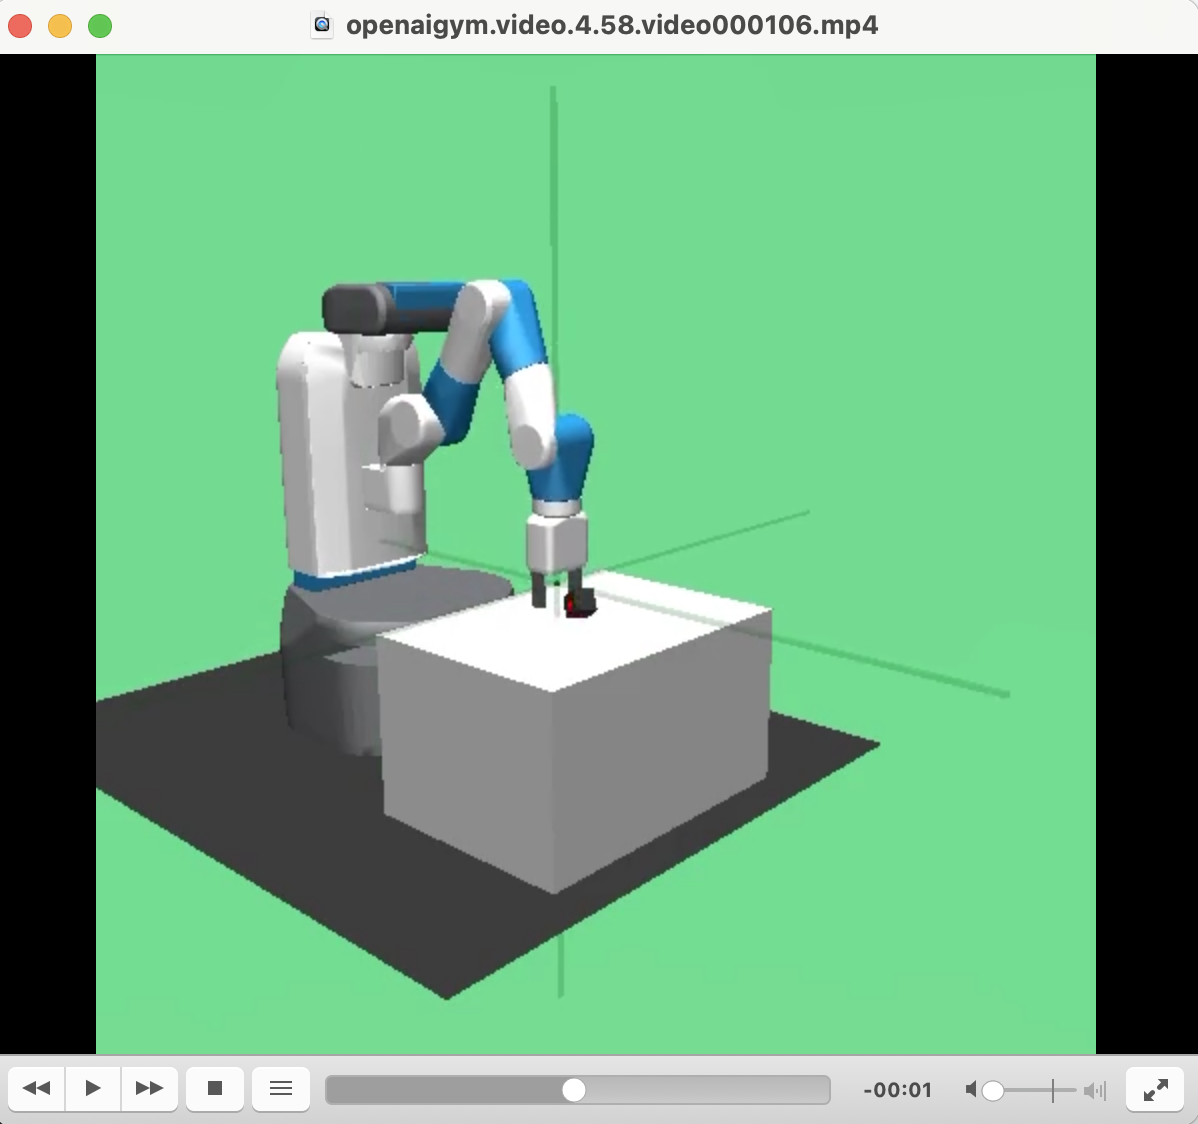

# Take Home

### Humanoid with PPO


In this Lab, I have already tried InvertedDoublePendulu, Ant(4 legs animal) and FetchPickAndPlace for PPO. So, now I tried Humanoid for PPO take home exercise.

In [ ]:
ENV_NAME = "Humanoid"
TRAIN_FLAG = True
test_env = gym.make(ENV_NAME + "-v2")

n_states = test_env.observation_space.shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
n_actions = test_env.action_space.shape[0]

In [ ]:
print(f"number of states:{n_states}\n"
      f"action bounds:{action_bounds}\n"
      f"number of actions:{n_actions}")

if not os.path.exists(ENV_NAME):
    os.mkdir(ENV_NAME)
    os.mkdir(ENV_NAME + "/logs")

env = gym.make(ENV_NAME + "-v2")

agent = Agent(n_states=n_states,
              n_iter=n_iterations,
              env_name=ENV_NAME,
              action_bounds=action_bounds,
              n_actions=n_actions,
              lr=lr)
if TRAIN_FLAG:
    trainer = Train(env=env,
                    test_env=test_env,
                    env_name=ENV_NAME,
                    agent=agent,
                    horizon=T,
                    n_iterations=n_iterations,
                    epochs=epochs,
                    mini_batch_size=mini_batch_size,
                    epsilon=clip_range)
    trainer.step()

player = Play(env, agent, ENV_NAME)
player.evaluate()

number of states:376
action bounds:[-0.4, 0.4]
number of actions:17
iteration:  1 	eval_rewards:  143.15736124981203
iteration:  2 	eval_rewards:  131.4511843905099
iteration:  3 	eval_rewards:  144.6173321616741
iteration:  4 	eval_rewards:  93.28572179050539
iteration:  5 	eval_rewards:  98.52909047192348
iteration:  6 	eval_rewards:  176.85550847116176
iteration:  7 	eval_rewards:  222.288420580107
iteration:  8 	eval_rewards:  166.71971782433545
iteration:  9 	eval_rewards:  229.69841565937216
iteration:  10 	eval_rewards:  133.40805634697935
iteration:  11 	eval_rewards:  156.350102919167
iteration:  12 	eval_rewards:  273.1542224001928
iteration:  13 	eval_rewards:  331.76494729778733
iteration:  14 	eval_rewards:  337.86891653585445
iteration:  15 	eval_rewards:  239.13549677957872
iteration:  16 	eval_rewards:  398.14874145346596
iteration:  17 	eval_rewards:  245.2663828300747
iteration:  18 	eval_rewards:  200.4940424411843
iteration:  19 	eval_rewards:  149.97028679666826
it

In Humanoid with PPO, 
- evaluation rewards : 495.579,
- running reward : 432.703
- Actor_Loss:0.051
- Critic_Loss:107.269
- iteration:  500


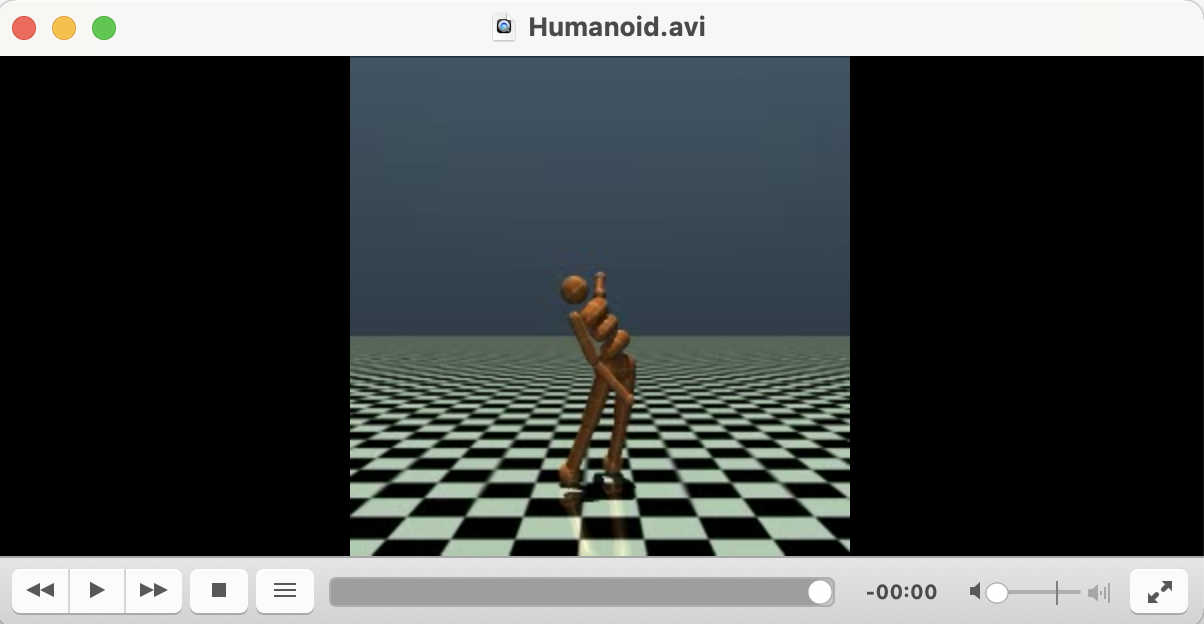

### HandReach with DDPG 

Since I have already tried FetchPickAndPlace for DDPG, now I tried HandReach for DDPG take home exercise.

Epoch:0| Running_reward:-50.000| EP_reward:-50.000| Memory_length:100| Duration:78.123| Actor_Loss:1.625| Critic_Loss:0.016| Success rate:0.000| 1.4/12.7 GB RAM
Epoch:1| Running_reward:-50.000| EP_reward:-50.000| Memory_length:200| Duration:81.702| Actor_Loss:1.647| Critic_Loss:0.026| Success rate:0.000| 1.4/12.7 GB RAM
Epoch:2| Running_reward:-50.000| EP_reward:-50.000| Memory_length:300| Duration:88.778| Actor_Loss:1.741| Critic_Loss:0.026| Success rate:0.000| 1.6/12.7 GB RAM
Epoch:3| Running_reward:-50.000| EP_reward:-50.000| Memory_length:400| Duration:83.438| Actor_Loss:1.650| Critic_Loss:0.018| Success rate:0.000| 1.6/12.7 GB RAM
Epoch:4| Running_reward:-50.000| EP_reward:-50.000| Memory_length:500| Duration:82.408| Actor_Loss:1.191| Critic_Loss:0.029| Success rate:0.000| 1.6/12.7 GB RAM
Epoch:5| Running_reward:-50.000| EP_reward:-50.000| Memory_length:600| Duration:83.251| Actor_Loss:1.456| Critic_Loss:0.027| Success rate:0.000| 1.6/12.7 GB RAM
Epoch:6| Running_reward:-50.000| E

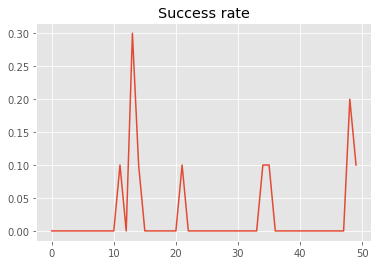

In [ ]:
import gym
# from agent import Agent
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
# from play import Play
import mujoco_py
import random
from mpi4py import MPI
import psutil
import time
from copy import deepcopy as dc
import os
import torch

ENV_NAME = "HandReach-v0"
# "RepeatCopy-v0"
# "ReversedAddition-v0"
# "FetchSlide-v1"
# "FetchPickAndPlace-v1"
INTRO = False
Train = True
Play_FLAG = False
MAX_EPOCHS = 50
MAX_CYCLES = 50
num_updates = 40
MAX_EPISODES = 2
memory_size = 7e+5 // 50
batch_size = 256
actor_lr = 1e-3
critic_lr = 1e-3
gamma = 0.98
tau = 0.05
k_future = 4

test_env = gym.make(ENV_NAME)
state_shape = test_env.observation_space.spaces["observation"].shape
#state_shape = test_env.observation_space.shape
n_actions = test_env.action_space.shape[0]
n_goals = test_env.observation_space.spaces["desired_goal"].shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
to_gb = lambda in_bytes: in_bytes / 1024 / 1024 / 1024

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['IN_MPI'] = '1'


def eval_agent(env_, agent_):
    total_success_rate = []
    running_r = []
    for ep in range(10):
        per_success_rate = []
        env_dictionary = env_.reset()
        s = env_dictionary["observation"]
        ag = env_dictionary["achieved_goal"]
        g = env_dictionary["desired_goal"]
        while np.linalg.norm(ag - g) <= 0.05:
            env_dictionary = env_.reset()
            s = env_dictionary["observation"]
            ag = env_dictionary["achieved_goal"]
            g = env_dictionary["desired_goal"]
        ep_r = 0
        for t in range(50):
            with torch.no_grad():
                a = agent_.choose_action(s, g, train_mode=False)
            observation_new, r, _, info_ = env_.step(a)
            s = observation_new['observation']
            g = observation_new['desired_goal']
            per_success_rate.append(info_['is_success'])
            ep_r += r
        total_success_rate.append(per_success_rate)
        if ep == 0:
            running_r.append(ep_r)
        else:
            running_r.append(running_r[-1] * 0.99 + 0.01 * ep_r)
    total_success_rate = np.array(total_success_rate)
    local_success_rate = np.mean(total_success_rate[:, -1])
    global_success_rate = MPI.COMM_WORLD.allreduce(local_success_rate, op=MPI.SUM)
    return global_success_rate / MPI.COMM_WORLD.Get_size(), running_r, ep_r

if INTRO:
    print(f"state_shape:{state_shape[0]}\n"
          f"number of actions:{n_actions}\n"
          f"action boundaries:{action_bounds}\n"
          f"max timesteps:{test_env._max_episode_steps}")
    for _ in range(3):
        done = False
        test_env.reset()
        while not done:
            action = test_env.action_space.sample()
            test_state, test_reward, test_done, test_info = test_env.step(action)
            # substitute_goal = test_state["achieved_goal"].copy()
            # substitute_reward = test_env.compute_reward(
            #     test_state["achieved_goal"], substitute_goal, test_info)
            # print("r is {}, substitute_reward is {}".format(r, substitute_reward))
            test_env.render()
    exit(0)

env = gym.make(ENV_NAME)
env.seed(MPI.COMM_WORLD.Get_rank())
random.seed(MPI.COMM_WORLD.Get_rank())
np.random.seed(MPI.COMM_WORLD.Get_rank())
torch.manual_seed(MPI.COMM_WORLD.Get_rank())
agent = Agent(n_states=state_shape,
              n_actions=n_actions,
              n_goals=n_goals,
              action_bounds=action_bounds,
              capacity=memory_size,
              action_size=n_actions,
              batch_size=batch_size,
              actor_lr=actor_lr,
              critic_lr=critic_lr,
              gamma=gamma,
              tau=tau,
              k_future=k_future,
              env=dc(env))



if Train:

    t_success_rate = []
    total_ac_loss = []
    total_cr_loss = []
    for epoch in range(MAX_EPOCHS):
        start_time = time.time()
        epoch_actor_loss = 0
        epoch_critic_loss = 0
        for cycle in range(0, MAX_CYCLES):
            mb = []
            cycle_actor_loss = 0
            cycle_critic_loss = 0
            for episode in range(MAX_EPISODES):
                episode_dict = {
                    "state": [],
                    "action": [],
                    "info": [],
                    "achieved_goal": [],
                    "desired_goal": [],
                    "next_state": [],
                    "next_achieved_goal": []}
                env_dict = env.reset()
                state = env_dict["observation"]
                achieved_goal = env_dict["achieved_goal"]
                desired_goal = env_dict["desired_goal"]
                while np.linalg.norm(achieved_goal - desired_goal) <= 0.05:
                    env_dict = env.reset()
                    state = env_dict["observation"]
                    achieved_goal = env_dict["achieved_goal"]
                    desired_goal = env_dict["desired_goal"]
                for t in range(500):
                    action = agent.choose_action(state, desired_goal)
                    next_env_dict, reward, done, info = env.step(action)

                    next_state = next_env_dict["observation"]
                    next_achieved_goal = next_env_dict["achieved_goal"]
                    next_desired_goal = next_env_dict["desired_goal"]

                    episode_dict["state"].append(state.copy())
                    episode_dict["action"].append(action.copy())
                    episode_dict["achieved_goal"].append(achieved_goal.copy())
                    episode_dict["desired_goal"].append(desired_goal.copy())

                    state = next_state.copy()
                    achieved_goal = next_achieved_goal.copy()
                    desired_goal = next_desired_goal.copy()
                    
                    if done:
                        break

                episode_dict["state"].append(state.copy())
                episode_dict["achieved_goal"].append(achieved_goal.copy())
                episode_dict["desired_goal"].append(desired_goal.copy())
                episode_dict["next_state"] = episode_dict["state"][1:]
                episode_dict["next_achieved_goal"] = episode_dict["achieved_goal"][1:]
                mb.append(dc(episode_dict))

            agent.store(mb)
            for n_update in range(num_updates):
                actor_loss, critic_loss = agent.train()
                cycle_actor_loss += actor_loss
                cycle_critic_loss += critic_loss

            epoch_actor_loss += cycle_actor_loss / num_updates
            epoch_critic_loss += cycle_critic_loss /num_updates
            agent.update_networks()

        ram = psutil.virtual_memory()
        success_rate, running_reward, episode_reward = eval_agent(env, agent)
        total_ac_loss.append(epoch_actor_loss)
        total_cr_loss.append(epoch_critic_loss)
        if MPI.COMM_WORLD.Get_rank() == 0:
            t_success_rate.append(success_rate)
            print(f"Epoch:{epoch}| "
                  f"Running_reward:{running_reward[-1]:.3f}| "
                  f"EP_reward:{episode_reward:.3f}| "
                  f"Memory_length:{len(agent.memory)}| "
                  f"Duration:{time.time() - start_time:.3f}| "
                  f"Actor_Loss:{actor_loss:.3f}| "
                  f"Critic_Loss:{critic_loss:.3f}| "
                  f"Success rate:{success_rate:.3f}| "
                  f"{to_gb(ram.used):.1f}/{to_gb(ram.total):.1f} GB RAM")
            agent.save_weights()

    if MPI.COMM_WORLD.Get_rank() == 0:

        with SummaryWriter("logs") as writer:
            for i, success_rate in enumerate(t_success_rate):
                writer.add_scalar("Success_rate", success_rate, i)

        plt.style.use('ggplot')
        plt.figure()
        plt.plot(np.arange(0, MAX_EPOCHS), t_success_rate)
        plt.title("Success rate")
        plt.savefig("success_rate.png")
        plt.show()

elif Play_FLAG:
    player = Play(env, agent, max_episode=100)
    player.evaluate()

In [ ]:
player = Play(env, agent, max_episode=100)
player.evaluate()

episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-5.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-49.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-49.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-4.000
episode_reward:-50.000
episode_reward:-50.000
episode_rewar

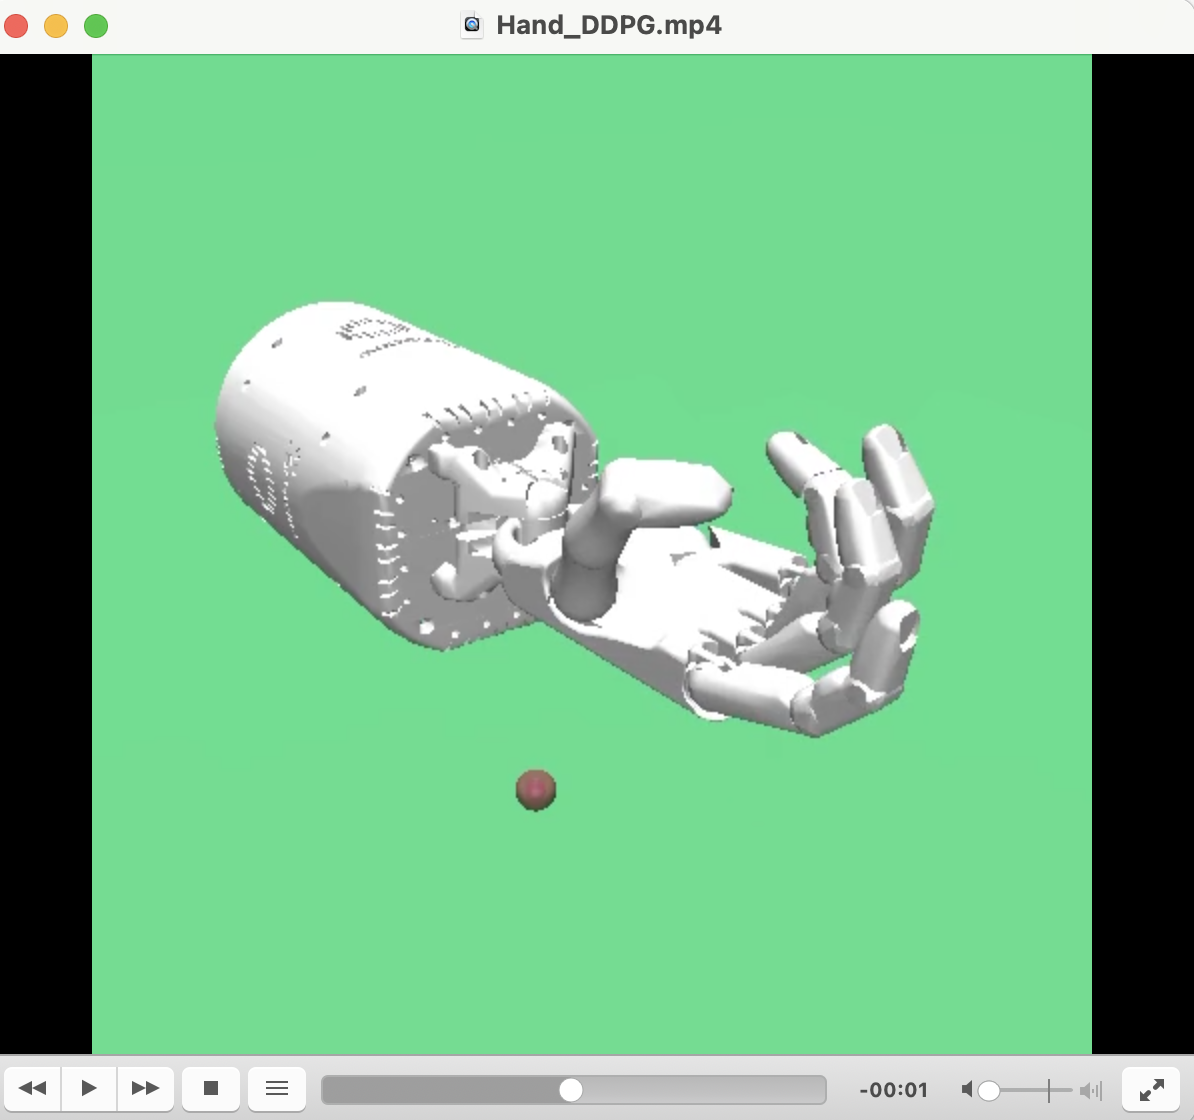